In [1]:
import numpy as np
import pandas as pd


In [2]:
import os
import zipfile

In [3]:
!pip install tf-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/temp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Datathon-Dataset.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/tmp')
zip_train.close()

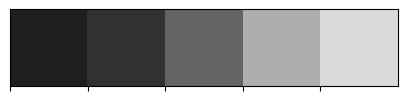

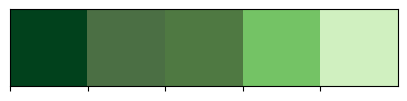

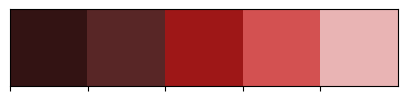

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels=['no_tumor','category3_tumor','category2_tumor','category1_tumor']


In [ ]:
X = []
y = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../tmp/Datathon-Dataset',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

100%|██████████| 916/916 [00:05<00:00, 173.79it/s]


In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
X, y = shuffle(X,y, random_state=101)

In [ ]:
X.shape

(3224, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.1,random_state=101)

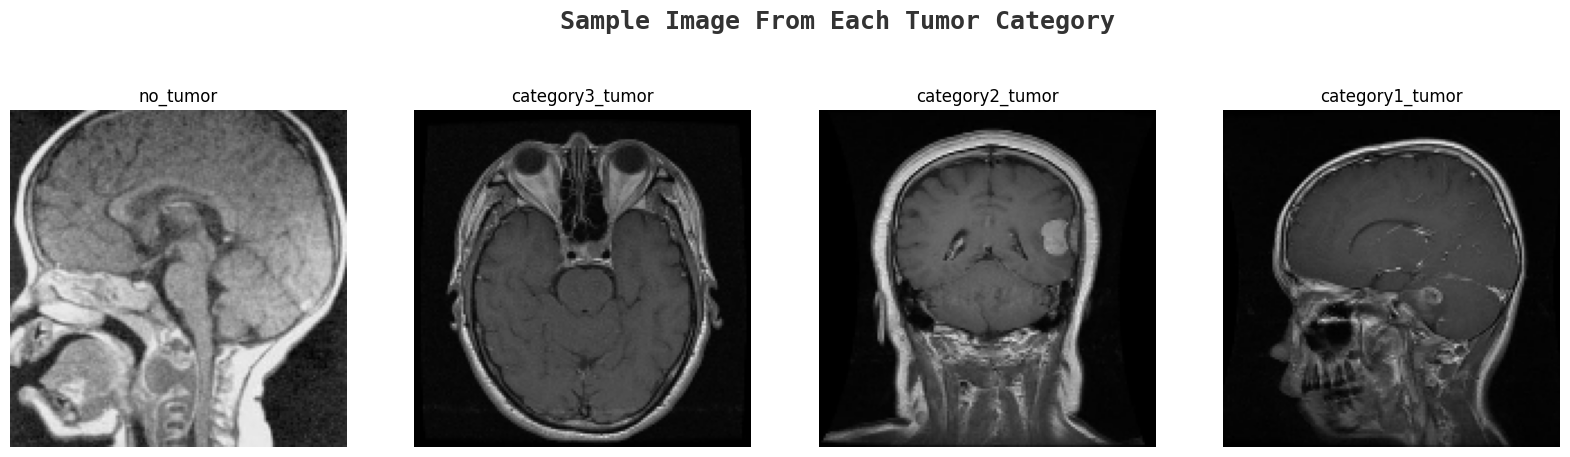

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Tumor Category',size=18,fontweight='bold',
             fontname='monospace',color="black",y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
82/82 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8199
Epoch 1: val_accuracy improved from -inf to 0.90034, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 408s 5s/step - loss: 0.4836 - accuracy: 0.8199 - val_loss: 0.4039 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 2/12
82/82 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9391
Epoch 2: val_accuracy did not improve from 0.90034
82/82 [==============================] - 380s 5s/step - loss: 0.1947 - accuracy: 0.9391 - val_loss: 0.3883 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 3/12
82/82 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9559
Epoch 3: val_accuracy improved from 0.90034 to 0.93814, saving model to effnet.h5
82/82 [==============================] - 382s 5s/step - loss: 0.1273 - accuracy: 0.9559 - val_loss: 0.2130 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 4/12
82/82 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9644
Epoch 4: val_accuracy did not improve from 0.93814
82/82 [==============================] - 373s 5s/step - loss: 0.1041 - accuracy: 0.9644 - val_loss: 0.460

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 14s 950ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.98      1.00      0.99        95
           2       1.00      0.98      0.99        93
           3       1.00      0.99      0.99        81

    accuracy                           0.99       323
   macro avg       0.99      0.99      0.99       323
weighted avg       0.99      0.99      0.99       323



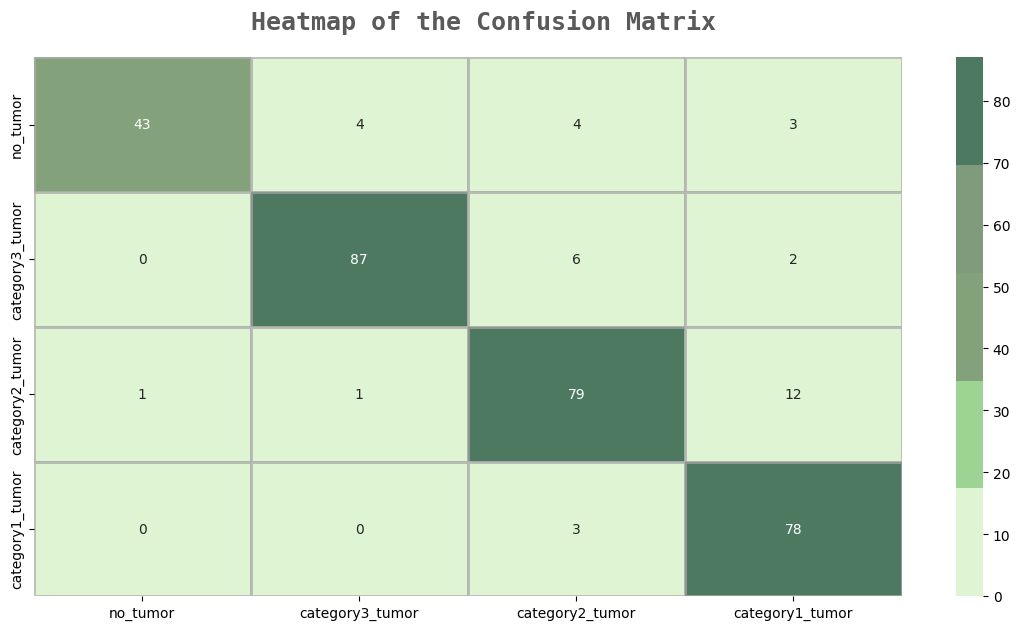

In [ ]:
#fig,ax=plt.subplots(1,1,figsize=(14,7))
#sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           #cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
#fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
            # fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

#plt.show()

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

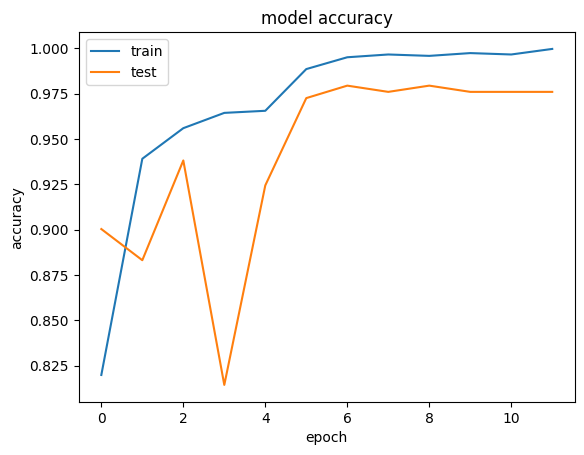

In [ ]:
plot_hist(history)

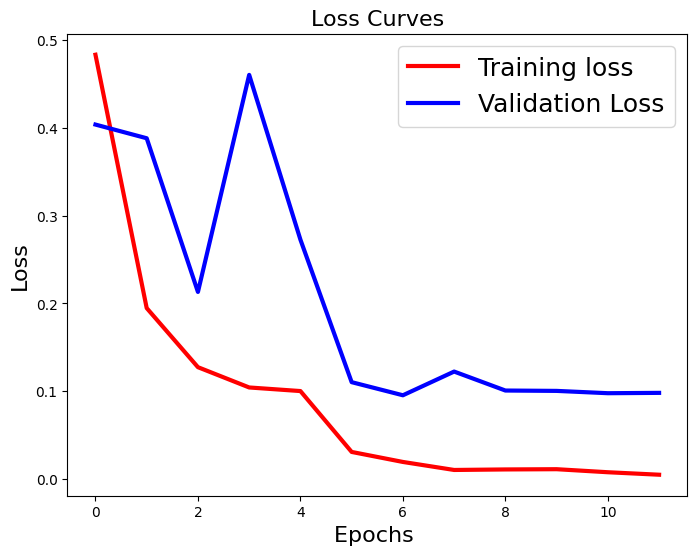

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

In [ ]:
tf.__version__

'2.12.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.3 MB/s eta 0:00:00
